# Credit Risk/Ratings Prediction

##### Aidan Cremins, Peyton Lewis, Joe Morris, Amrit Sandhu

TO DO: 
- univariate exploration each variable w target (correlation and regression)
- patterns among the firms that were miscategorized

### Necessary Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

##### Plot Styling

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.style.use('fivethirtyeight')
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18

### Get Data

#### Read in Credit Ratings

In [3]:
credit_ratings_file = "ratios_with_credit_ratings_all.csv"
all_data = pd.read_csv(credit_ratings_file)
all_data.dropna(inplace=True)

all_data.drop(all_data.columns[0], axis=1, inplace=True)
all_data["rating"] = all_data["long_term_credit_rating"].apply(lambda x: 1 if x[0] == "A" else (1 if x[0:3] == "BBB" else 0))

#### Test Train Split

In [4]:
all_data = pd.get_dummies(all_data, drop_first=True, columns=['gicdesc'])
print(all_data.columns)

Index(['gsector', 'public_date', 'ticker', 'roa', 'intcov_ratio',
       'quick_ratio', 'intcov', 'bm', 'npm', 'debt_assets', 'debt_ebitda',
       'inv_turn', 'cash_ratio', 'long_term_credit_rating', 'rating',
       'gicdesc_Consumer Discretionary', 'gicdesc_Consumer Staples',
       'gicdesc_Energy', 'gicdesc_Financials', 'gicdesc_Health Care',
       'gicdesc_Industrials', 'gicdesc_Information Technology',
       'gicdesc_Materials', 'gicdesc_Utilities'],
      dtype='object')


In [5]:
X = all_data.drop('rating', axis=1)
X.drop('gsector', axis = 1, inplace=True)
y = all_data['rating']

dict_interest = {'gicdesc_Consumer Discretionary': 'Consumer Discretionary', 'gicdesc_Consumer Staples': 'Consumer Staples', 'gicdesc_Energy': 'Energy', 'gicdesc_Financials': 'Financials', 'gicdesc_Health Care': 'Health Care', 'gicdesc_Industrials': 'Industrials', 'gicdesc_Information Technology': 'Information Technology', 'gicdesc_Materials': 'Materials', 'gicdesc_Utilities': 'Utilities', 'roa': 'ROA', 'intcov_ratio': 'Interest Coverage Ratio',  'quick_ratio': 'Quick Ratio', 'intcov': 'Interest Coverage', 'bm': 'Book to Market', 'npm': 'Net Profit Margin',  'debt_assets': 'Debt Assets', 'debt_ebitda': 'Debt Ebitda', 'inv_turn': 'Inventory Turnover', 'cash_ratio': 'Cash Ratio'}

y = y.rename({'rating': 'Rating'})
X = X.rename(columns=dict_interest)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

columnsOfInterest = ['gicdesc_Consumer Discretionary', 'gicdesc_Consumer Staples',\
       'gicdesc_Energy', 'gicdesc_Financials', 'gicdesc_Health Care',\
       'gicdesc_Industrials', 'gicdesc_Information Technology',\
       'gicdesc_Materials', 'gicdesc_Utilities', 'roa', 'intcov_ratio', \
        'quick_ratio', 'intcov', 'bm', 'npm', 'debt_assets', 'debt_ebitda', \
            'inv_turn', 'cash_ratio']

X_train = X_train[dict_interest.values()]
X_test = X_test[dict_interest.values()]

### Feature Selection

#### Correlation Matrix

Text(0.5, 1.0, 'Correlation Heatmap')

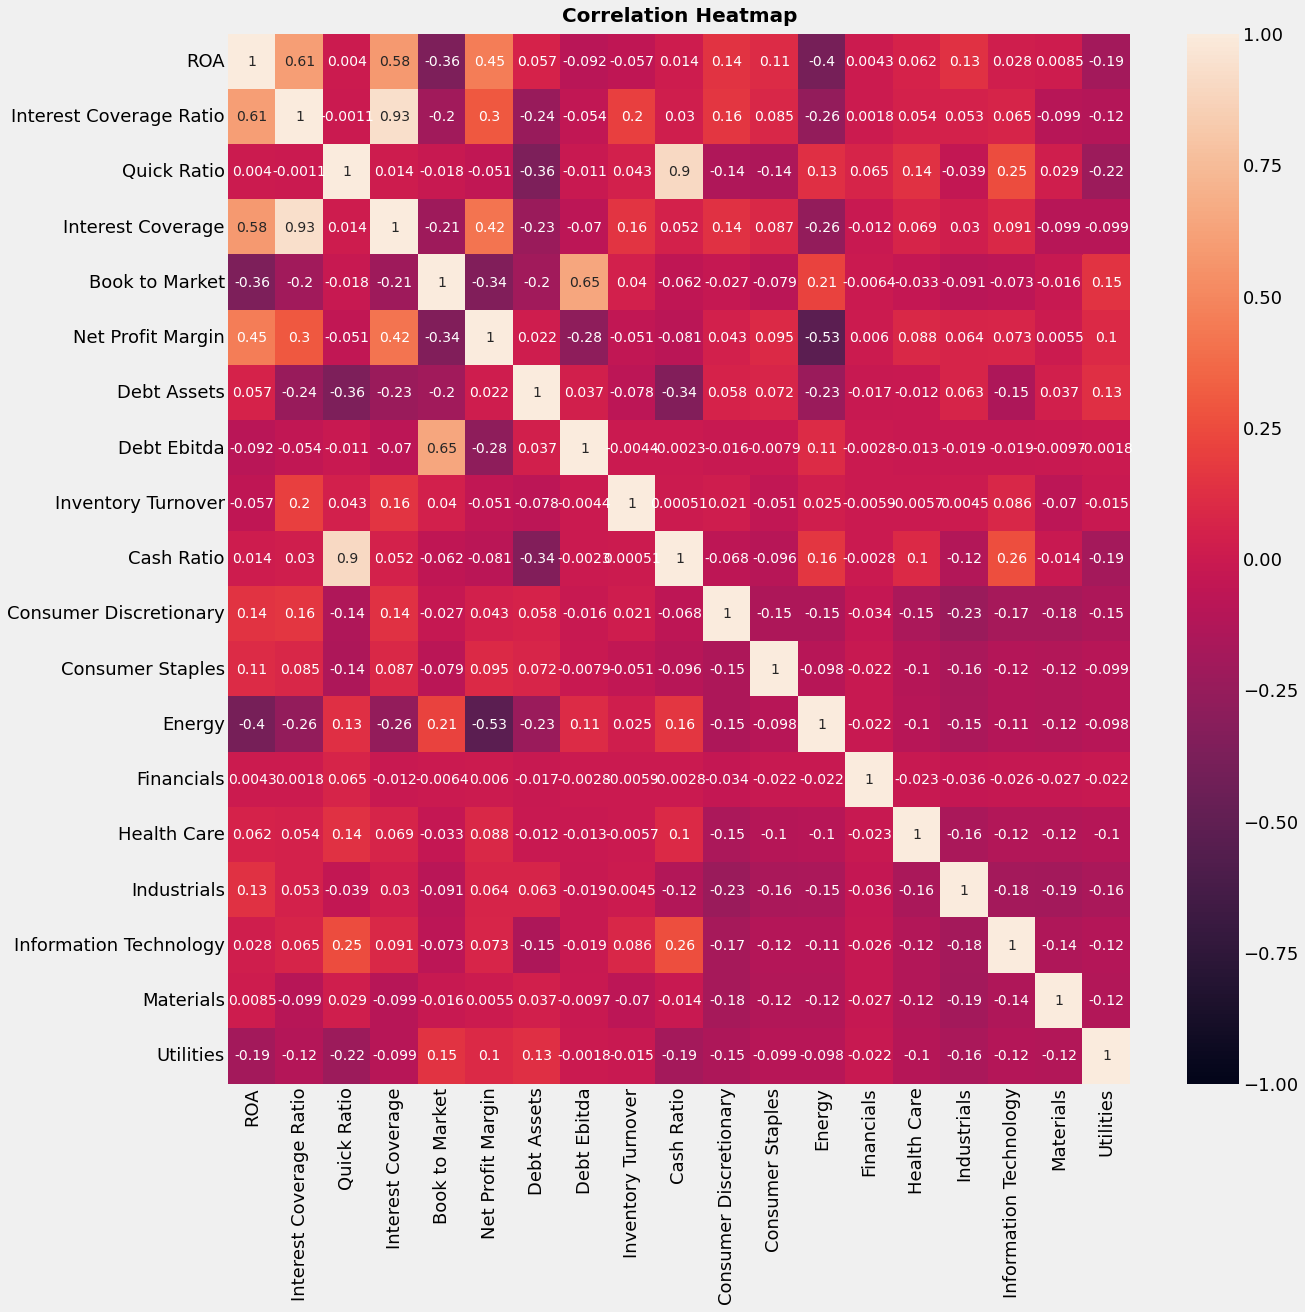

In [6]:
corr = X.corr()
plt.figure(figsize=(18, 18))
heatmap = sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12)

#### Univariate Exploration of Predictors

Interest Coverage          0.306597
Interest Coverage Ratio    0.291237
Utilities                  0.270493
Net Profit Margin          0.263332
ROA                        0.226609
Consumer Staples           0.068325
Health Care                0.059703
Information Technology    -0.024371
Financials                -0.028651
Industrials               -0.045833
Cash Ratio                -0.054128
Energy                    -0.056634
Debt Ebitda               -0.057253
Inventory Turnover        -0.075738
Materials                 -0.091705
Consumer Discretionary    -0.101955
Quick Ratio               -0.130809
Book to Market            -0.132010
Debt Assets               -0.146081
Name: Rating, dtype: float64


Text(0.5, 0, 'Predictor')

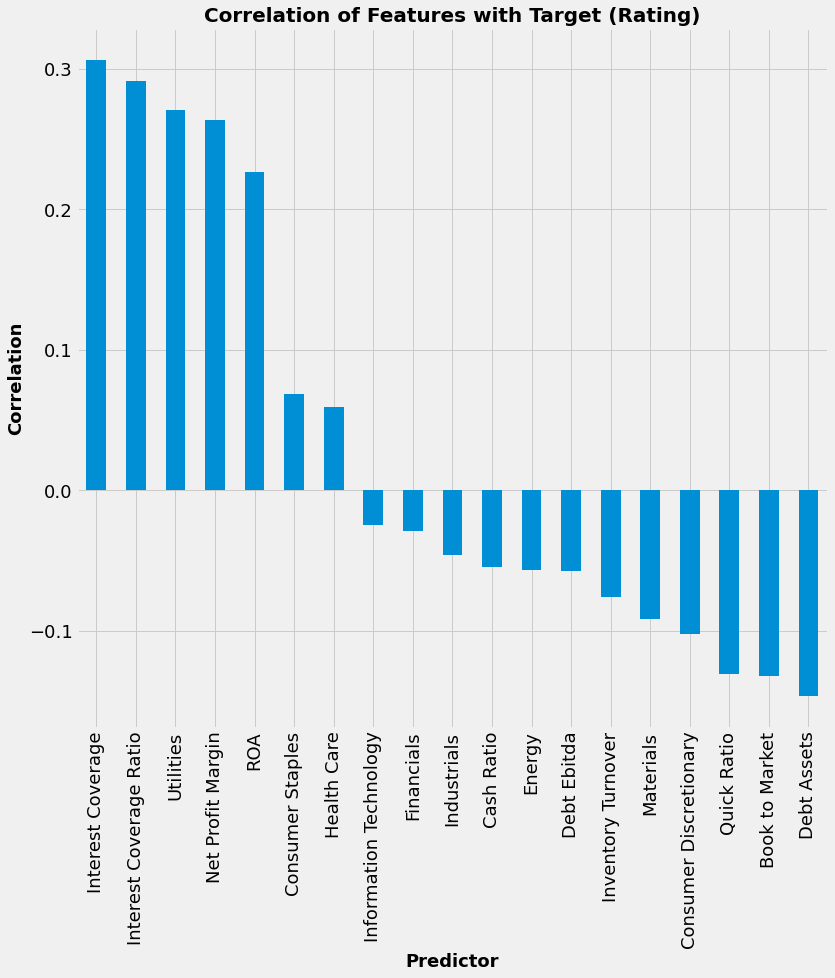

In [7]:
# Correlation of each feature with the target variable (rating)
data = X.copy()
data['Rating'] = y
plt.figure(figsize=(12, 12))
corr = data.corr()
corr.sort_values(["Rating"], ascending = False, inplace = True)
print(corr.Rating[1:])
corr.Rating[1:].plot(kind='bar')
plt.title("Correlation of Features with Target (Rating)")
plt.ylabel('Correlation')
plt.xlabel('Predictor')


#### Lasso for Feature Selection

##### Lasso Regression and Select Non-Zero Coefficients

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_lasso = scaler.fit_transform(X_train)
X_test_lasso = scaler.transform(X_test)

from sklearn.linear_model import LassoCV

clf = LassoCV().fit(X_train_lasso, y_train)

selectedFeatures = []
print("Columns selected are : ")
for i in range(len(clf.coef_)):
    if clf.coef_[i] != 0:
        print(dict_interest[columnsOfInterest[i]])
        selectedFeatures.append(i)

print("\n\nColumns dropped are : ")
for i in range(len(clf.coef_)):
    if clf.coef_[i] == 0:
        print(dict_interest[columnsOfInterest[i]])

Columns selected are : 
Consumer Discretionary
Energy
Health Care
Industrials
Information Technology
Materials
Utilities
ROA
Interest Coverage Ratio
Quick Ratio
Book to Market
Net Profit Margin
Debt Assets
Debt Ebitda
Inventory Turnover
Cash Ratio


Columns dropped are : 
Consumer Staples
Financials
Interest Coverage


##### Plot the Coefficients

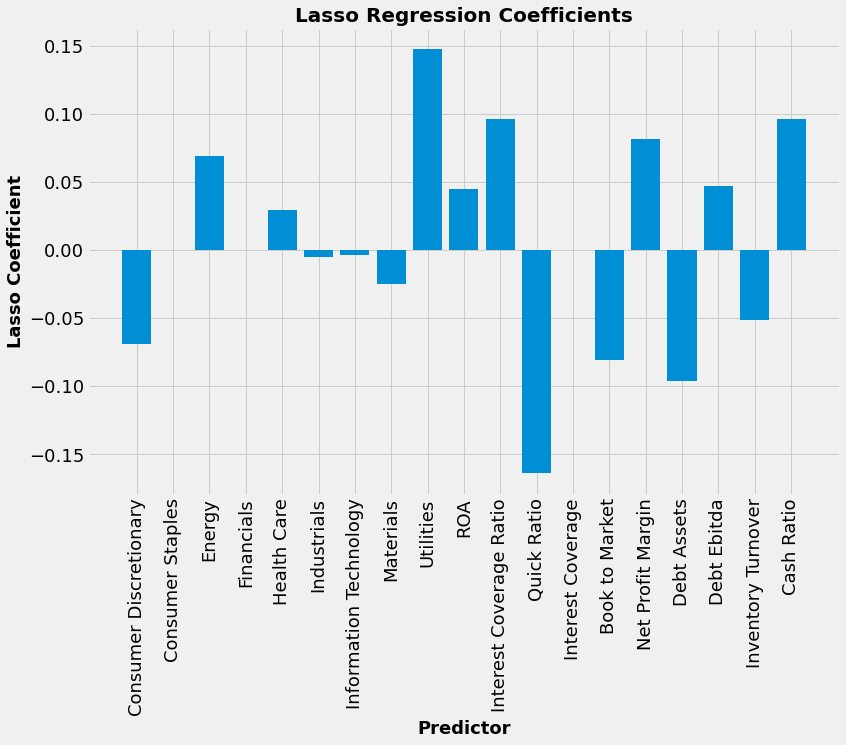

In [9]:
plt.bar(dict_interest.values(), clf.coef_)
plt.xticks(rotation=90)
plt.xlabel('Predictor')
plt.ylabel('Lasso Coefficient')
plt.title('Lasso Regression Coefficients')
plt.show()


#### PCA

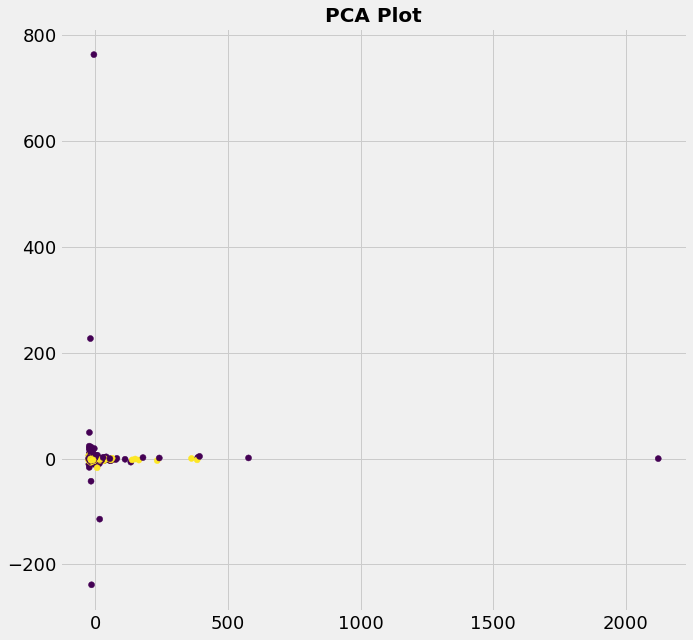

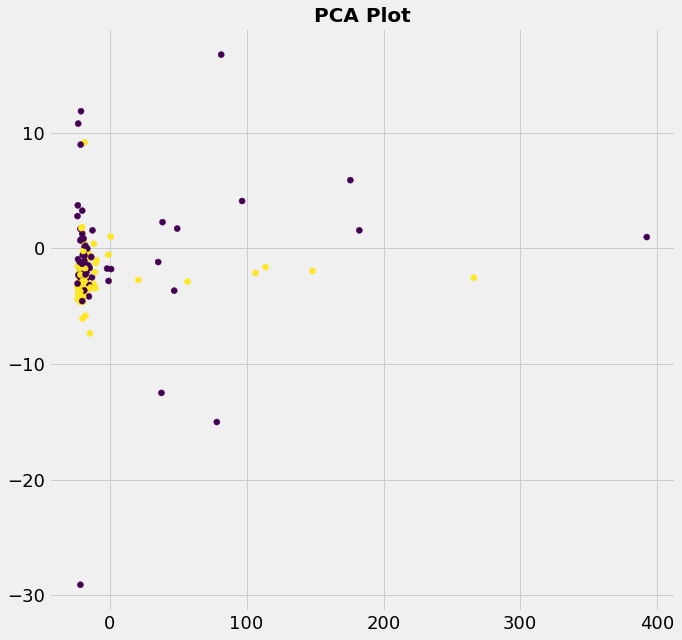

In [10]:
# Do pca, plot the first two principal components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train)
X_train2 = pca.transform(X_train)
X_test2 = pca.transform(X_test)

plt.figure(figsize=(10, 10))
plt.scatter(X_train2[:, 0], X_train2[:, 1], c=y_train)
plt.title('PCA Plot')
plt.show()

# Pca plot for test data
plt.figure(figsize=(10, 10))
plt.scatter(X_test2[:, 0], X_test2[:, 1], c=y_test)
plt.title('PCA Plot')
plt.show()

#### Change X_train and X_test to Only Columns of Interest

In [11]:
selectedFeatures_names = [columnsOfInterest[i] for i in selectedFeatures]
selectedFeatures_names.append('gicdesc_Consumer Staples')
selectedFeatures_names.append('gicdesc_Financials')
selectedFeatures_names.remove('cash_ratio')

selectedFeatures_names = [dict_interest[i] for i in selectedFeatures_names]

X_train = X_train[selectedFeatures_names]
X_test = X_test[selectedFeatures_names]

X_train

,Consumer Discretionary,Energy,Health Care,Industrials,Information Technology,Materials,Utilities,ROA,Interest Coverage Ratio,Quick Ratio,Book to Market,Net Profit Margin,Debt Assets,Debt Ebitda,Inventory Turnover,Consumer Staples,Financials
29,0,1,0,0,0,0,0,0.101847,3.551547,5.029421,3.806594,0.270987,0.316093,2.864391,3.067427,0,0
666,0,0,0,0,0,1,0,0.020332,-2.309417,1.155721,1.158963,-0.191355,0.508770,7.633208,5.351364,0,0
444,0,0,0,1,0,0,0,0.184457,6.121827,0.818182,0.217611,0.086854,0.744954,2.445495,92.219780,0,0
173,0,1,0,0,0,0,0,0.069970,-4.314494,4.188895,0.691222,-0.068733,0.326807,1.046907,6.737834,0,0
694,0,0,0,0,0,0,0,0.110725,3.029511,0.930641,0.320311,0.066988,0.748901,4.811916,3.087314,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,0,0,0,0,0,0,1,0.067478,2.946752,1.316525,0.837092,0.157120,0.656931,4.254503,7.352066,0,0
208,0,0,0,1,0,0,0,0.130606,8.304481,0.665502,0.594001,0.204824,0.500482,2.211691,8.355938,0,0
107,0,0,0,1,0,0,0,0.234242,17.050847,0.845159,0.277916,0.124053,0.596688,1.607813,11.937366,0,0
324,0,0,0,0,0,1,0,0.161669,7.609300,1.215966,0.304566,0.059887,0.603715,1.639511,9.601169,0,0


### Functions for Statistics

#### Function to Create a Confusion Matrix

In [12]:
def create_confusion_matrix(test_vals, pred_vals, model_name):
    conf_mat = confusion_matrix(test_vals, pred_vals)
    sns.heatmap(conf_mat, annot=True, cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    
    #Change the 0's and 1's to the actual class names for clearer interpretation
    plt.xticks(ticks=[0.5,1.5], labels=['Sub-Investment Grade','Investment Grade'])
    plt.yticks(ticks=[0.5,1.5], labels=['Sub-Investment Grade','Investment Grade'])
    plt.title('Confusion Matrix for {} Model'.format(model_name))

#### Function to Create ROC Curve

In [13]:
def create_roc_curve(model, x_test, y_test, model_name):
    metrics.plot_roc_curve(model, x_test, y_test, name=model_name)
    plt.plot([0,1],[0,1], linestyle='--', label='Baseline Classifier',color = 'red')
    plt.grid()
    plt.legend()

#### Function to Create PR Curve

In [14]:
def create_pr_curve(model, x_test, y_test, model_name):
    metrics.plot_precision_recall_curve(model, x_test, y_test, name=model_name)
    positive_rate = sum(y_test)/len(y_test)
    plt.plot([0,1],[positive_rate,positive_rate], linestyle='--', label='Baseline Classifier',color = 'red')
    plt.grid()
    plt.legend()

### Logistic Regression

#### Create Model (Sklearn)

In [15]:
model = LogisticRegression(max_iter=1000)

result = model.fit(X_train, y_train)

In [16]:
y_pred = model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(model.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.76351


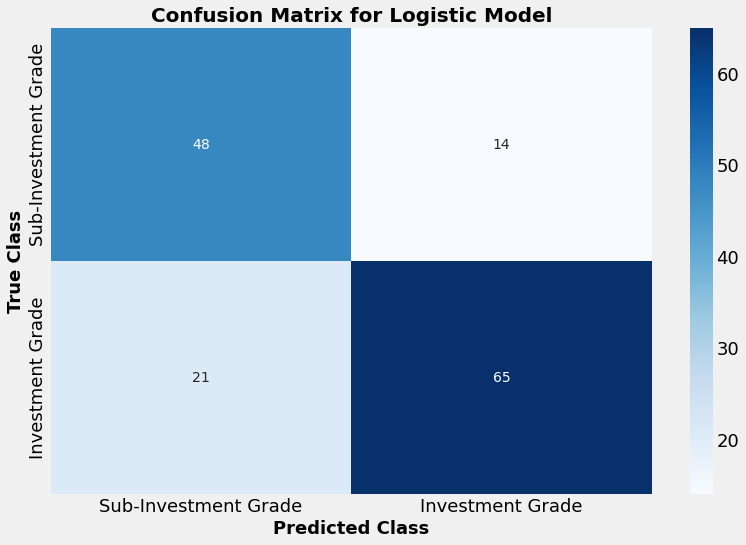

In [17]:
create_confusion_matrix(y_test, y_pred,'Logistic')

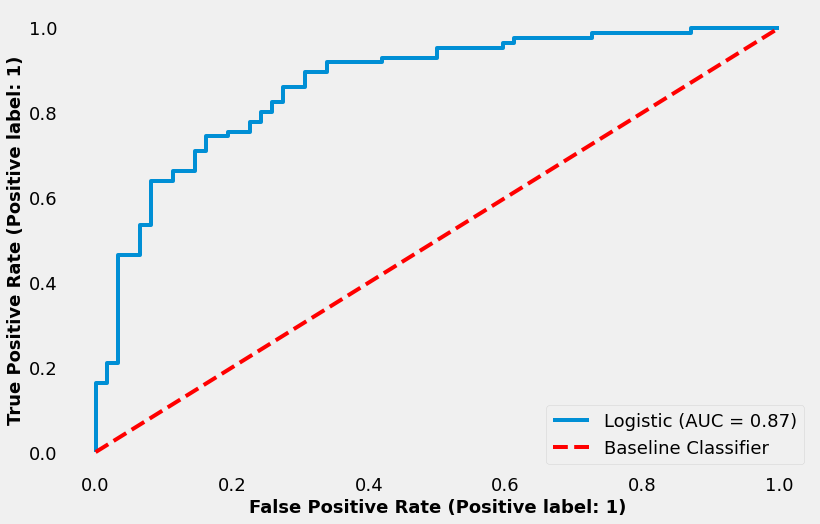

In [18]:
create_roc_curve(model, X_test, y_test, 'Logistic')

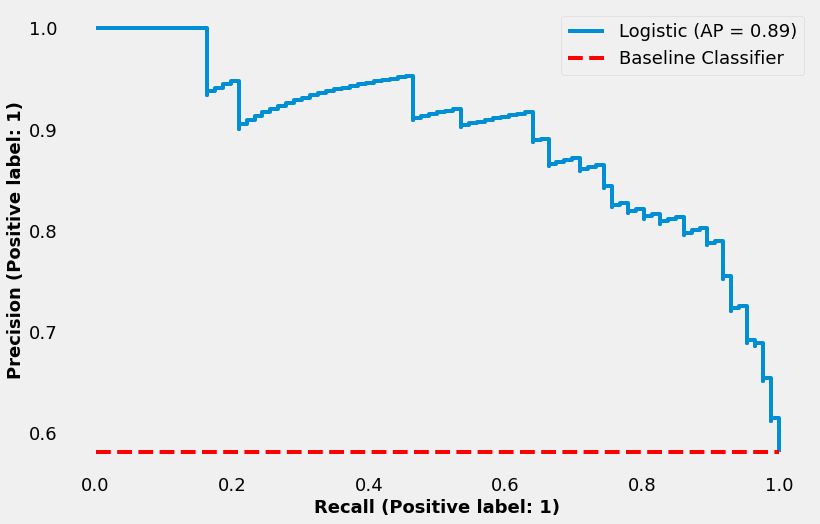

In [19]:
create_pr_curve(model, X_test, y_test, 'Logistic')

#### Create Model Statsmodels

In [20]:
import statsmodels.formula.api as smf

train = X_train.copy()
train['rating'] = y_train

formula_format = ''
for i in X_train.columns :
  formula_format += 'Q("' + i + '") + '

m1 = smf.logit(
  formula='rating ~ ' + formula_format[:-2],
  data=train) \
.fit()

m1.summary()

Optimization terminated successfully.
         Current function value: 0.491282
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 rating   No. Observations:                  441
Model:                          Logit   Df Residuals:                      423
Method:                           MLE   Df Model:                           17
Date:                Wed, 09 Nov 2022   Pseudo R-squ.:                  0.2906
Time:                        14:50:01   Log-Likelihood:                -216.66
converged:                       True   LL-Null:                       -305.42
Covariance Type:            nonrobust   LLR p-value:                 8.940e-29
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        4.7747      1.681      2.841      0.004       1.481       8.069
Q("Consumer Discretionary")     -2.1622      1.158     -1.868      0.062      -4.431       0.107
Q("Energy")                      0.7772      1.245      0.624      0.533      -1.664       3.218
Q("Health Care")                -0.8528      1.196     -0.713      0.476      -3.197       1.491
Q("Industrials")                -1.6128      1.151     -1.402      0.161      -3.868       0.643
Q("Information Technology")     -1.3626      1.169     -1.165      0.244      -3.655       0.929
Q("Materials")                  -1.6721      1.159     -1.442      0.149      -3.944       0.600
Q("Utilities")                   2.6467      1.334      1.985      0.047       0.033       5.260
Q("ROA")                        -1.2469      3.194     -0.390      0.696      -7.506       5.013
Q("Interest Coverage Ratio")     0.1077      0.030      3.567      0.000       0.049       0.167
Q("Quick Ratio")                -0.5314      0.174     -3.060      0.002      -0.872      -0.191
Q("Book to Market")             -1.6863      0.526     -3.205      0.001      -2.718      -0.655
Q("Net Profit Margin")           4.2146      1.519      2.775      0.006       1.238       7.192
Q("Debt Assets")                -4.0921      1.183     -3.460      0.001      -6.410      -1.774
Q("Debt Ebitda")                -0.0026      0.008     -0.323      0.746      -0.019       0.013
Q("Inventory Turnover")         -0.0047      0.001     -3.270      0.001      -0.007      -0.002
Q("Consumer Staples")           -1.3540      1.178     -1.150      0.250      -3.662       0.954
Q("Financials")                 -1.2056      1.818     -0.663      0.507      -4.769       2.358
================================================================================================
"""

In [61]:
m1.params#.values

rename = ['Intercept']

for i, item in enumerate(m1.params.index) :
    if i > 0 :
    #     m1.params.index[i] = item[3:-2]
    #     print(item[3:-2])
        rename.append(item[3:-2].replace(" ", "_"))

# print(rename)
print(rename)
m1.params.index = rename

print(m1.params.index)
m1.summary()


['Intercept', 'Consumer_Discretionary', 'Energy', 'Health_Care', 'Industrials', 'Information_Technology', 'Materials', 'Utilities', 'ROA', 'Interest_Coverage_Ratio', 'Quick_Ratio', 'Book_to_Market', 'Net_Profit_Margin', 'Debt_Assets', 'Debt_Ebitda', 'Inventory_Turnover', 'Consumer_Staples', 'Financials']
Index(['Intercept', 'Q("Consumer Discretionary")', 'Q("Energy")',
       'Q("Health Care")', 'Q("Industrials")', 'Q("Information Technology")',
       'Q("Materials")', 'Q("Utilities")', 'Q("ROA")',
       'Q("Interest Coverage Ratio")', 'Q("Quick Ratio")',
       'Q("Book to Market")', 'Q("Net Profit Margin")', 'Q("Debt Assets")',
       'Q("Debt Ebitda")', 'Q("Inventory Turnover")', 'Q("Consumer Staples")',
       'Q("Financials")'],
      dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 rating   No. Observations:                  441
Model:                          Logit   Df Residuals:                      423
Method:                           MLE   Df Model:                           17
Date:                Wed, 09 Nov 2022   Pseudo R-squ.:                  0.2906
Time:                        15:11:04   Log-Likelihood:                -216.66
converged:                       True   LL-Null:                       -305.42
Covariance Type:            nonrobust   LLR p-value:                 8.940e-29
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        4.7747      1.681      2.841      0.004       1.481       8.069
Q("Consumer Discretionary")     -2.1622      1.158     -1.868      0.062      -4.431       0.107
Q("Energy")                      0.7772      1.245      0.624      0.533      -1.664       3.218
Q("Health Care")                -0.8528      1.196     -0.713      0.476      -3.197       1.491
Q("Industrials")                -1.6128      1.151     -1.402      0.161      -3.868       0.643
Q("Information Technology")     -1.3626      1.169     -1.165      0.244      -3.655       0.929
Q("Materials")                  -1.6721      1.159     -1.442      0.149      -3.944       0.600
Q("Utilities")                   2.6467      1.334      1.985      0.047       0.033       5.260
Q("ROA")                        -1.2469      3.194     -0.390      0.696      -7.506       5.013
Q("Interest Coverage Ratio")     0.1077      0.030      3.567      0.000       0.049       0.167
Q("Quick Ratio")                -0.5314      0.174     -3.060      0.002      -0.872      -0.191
Q("Book to Market")             -1.6863      0.526     -3.205      0.001      -2.718      -0.655
Q("Net Profit Margin")           4.2146      1.519      2.775      0.006       1.238       7.192
Q("Debt Assets")                -4.0921      1.183     -3.460      0.001      -6.410      -1.774
Q("Debt Ebitda")                -0.0026      0.008     -0.323      0.746      -0.019       0.013
Q("Inventory Turnover")         -0.0047      0.001     -3.270      0.001      -0.007      -0.002
Q("Consumer Staples")           -1.3540      1.178     -1.150      0.250      -3.662       0.954
Q("Financials")                 -1.2056      1.818     -0.663      0.507      -4.769       2.358
================================================================================================
"""

In [21]:
from sklearn.metrics import accuracy_score

y_pred = m1.predict(X_test)
prediction = list(map(round, y_pred))
  
# confusion matrix
cm = metrics.confusion_matrix(y_test, prediction) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction))

Confusion Matrix : 
 [[49 13]
 [18 68]]
Test accuracy =  0.7905405405405406


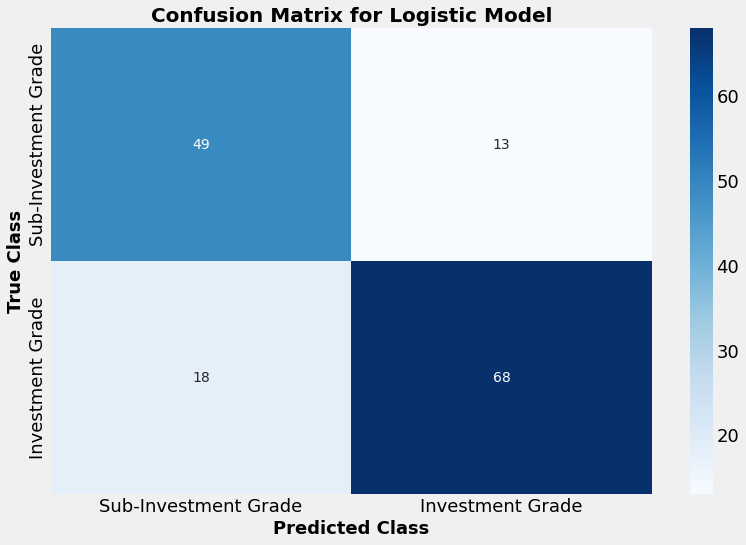

In [22]:
create_confusion_matrix(y_test, prediction,'Logistic')

### KNN

In [23]:
knn_results = {}

for k in range(1,26):
    knn = KNeighborsClassifier(n_neighbors = k)

    knn.fit(X_train, y_train)
    knn.predict(X_test)
    
    knn_results[k] = knn.score(X_test, y_test)

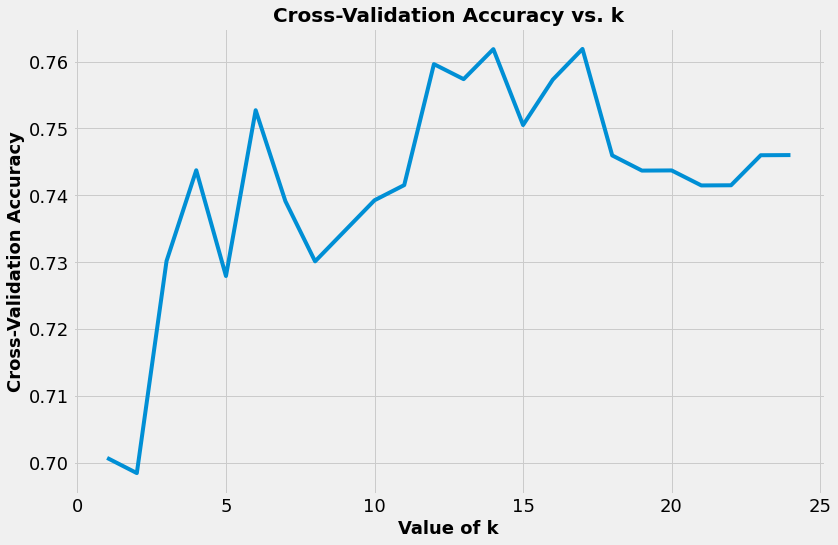

In [24]:
knn_results = []
for k in range(1,25):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    knn_results.append(scores.mean())

plt.plot(range(1,25), knn_results)
plt.xlabel('Value of k')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Accuracy vs. k')
plt.show()

In [25]:
knn_final = KNeighborsClassifier(n_neighbors = 14)
knn_final.fit(X_train,y_train)
knn_final_pred = knn_final.predict(X_test)
knn_final.score(X_test,y_test)

0.7162162162162162

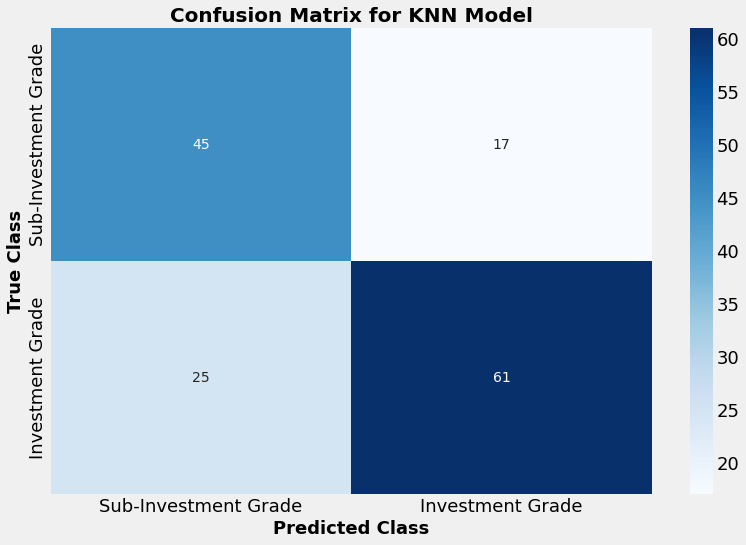

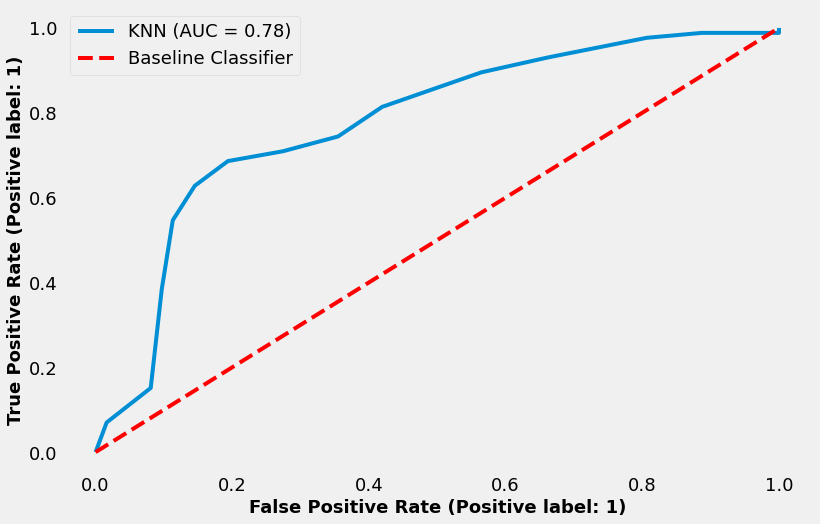

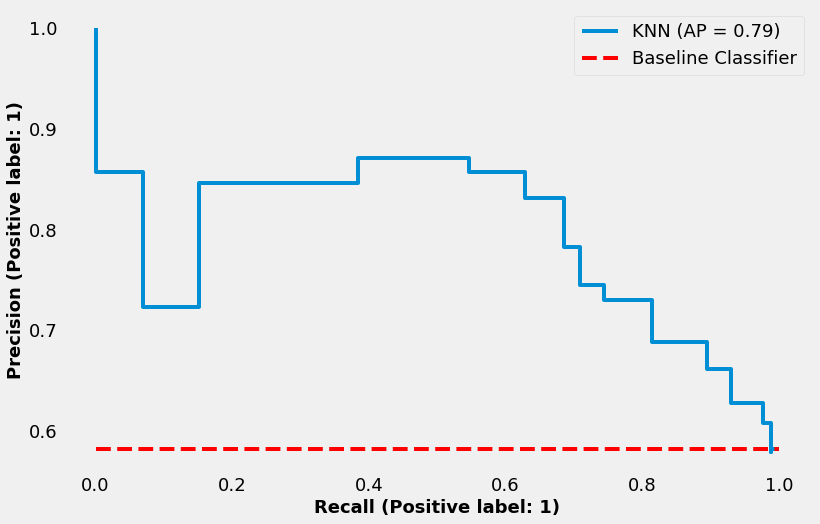

In [26]:
create_confusion_matrix(y_test, knn_final_pred,'KNN')
create_roc_curve(knn_final, X_test, y_test, 'KNN')
create_pr_curve(knn_final, X_test, y_test, 'KNN')

### Decision Trees

In [27]:
#Fit a basic decision tree model
tree_mod = DecisionTreeClassifier(max_depth=3,random_state=1)
tree_mod.fit(X_train,y_train)
tree_mod_pred = tree_mod.predict(X_test)
tree_mod.score(X_test,y_test)

0.7635135135135135

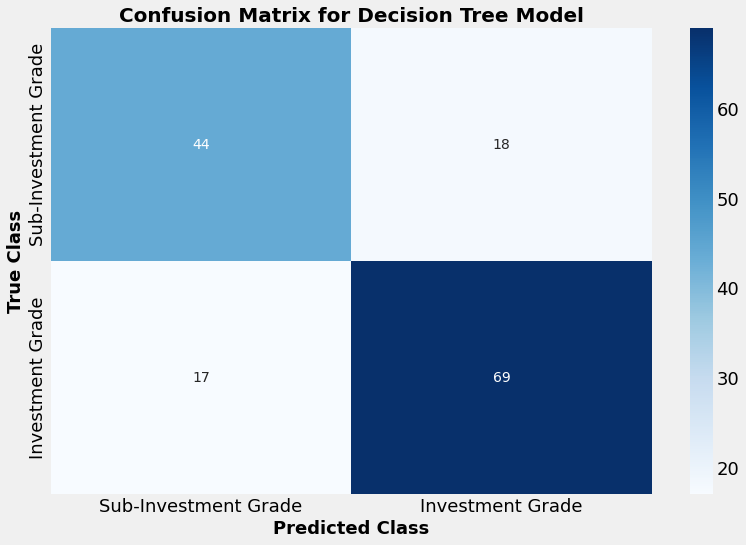

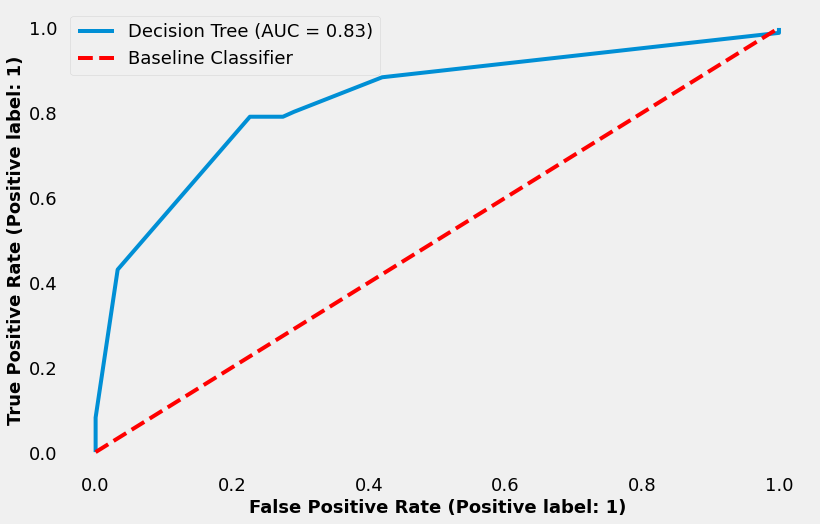

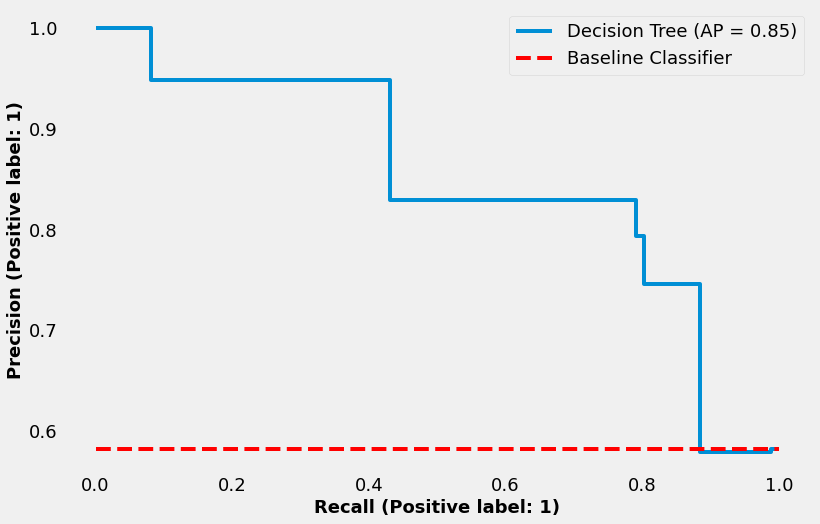

In [28]:
create_confusion_matrix(y_test, tree_mod_pred,'Decision Tree')
create_roc_curve(tree_mod, X_test, y_test, 'Decision Tree')
create_pr_curve(tree_mod, X_test, y_test, 'Decision Tree')

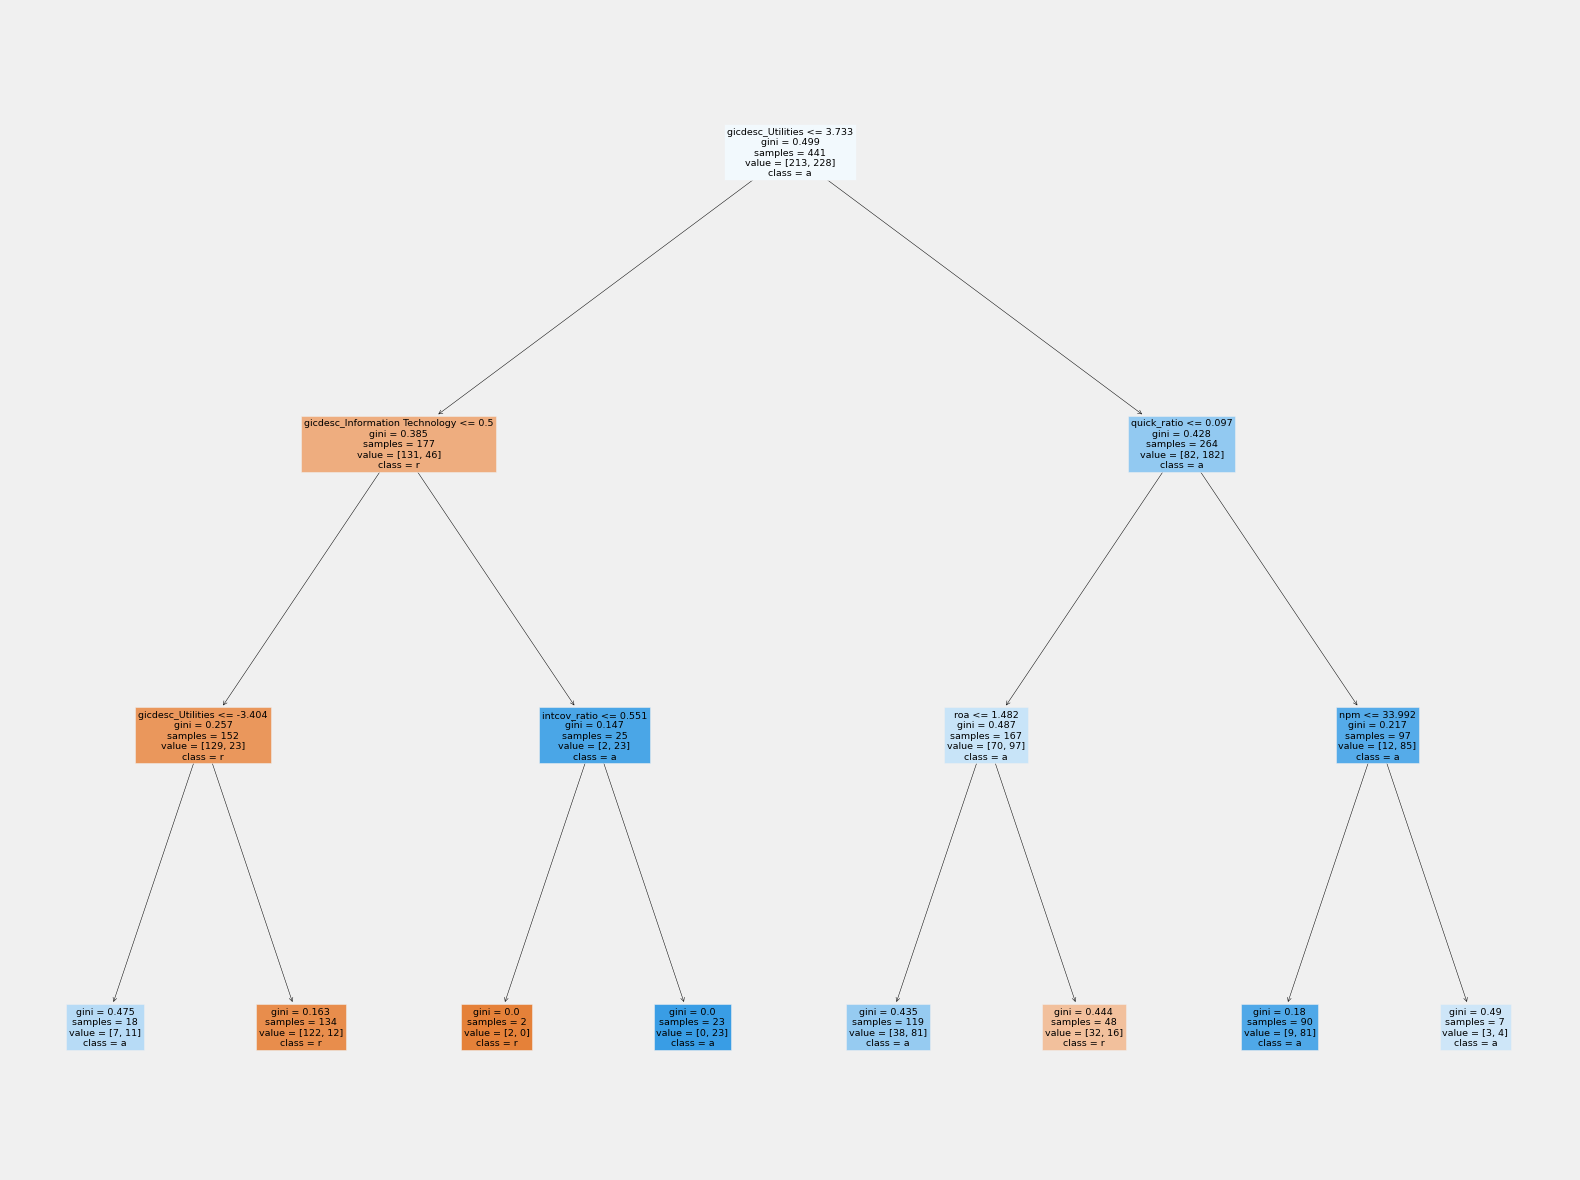

In [29]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_mod, 
                   feature_names=columnsOfInterest,  
                   class_names='rating',
                   filled=True)

In [30]:
n_estimators = [100,150,200,250,300] 
max_depth = [2,3,4,5,6] 
grid = {'n_estimators': n_estimators, 'max_depth': max_depth}
rf_mod_tuned = RandomForestClassifier(random_state=1)
rf_mod_tuned = GridSearchCV(estimator = rf_mod_tuned, param_grid = grid,
               cv = 5, verbose=2, n_jobs = -1)
rf_mod_tuned_fitted = rf_mod_tuned.fit(X_train,y_train)
rf_mod_tuned_pred = rf_mod_tuned_fitted.predict(X_test)
rf_mod_tuned_fitted.score(X_test,y_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


0.8445945945945946

In [31]:
rf_mod_tuned.best_params_

{'max_depth': 6, 'n_estimators': 100}

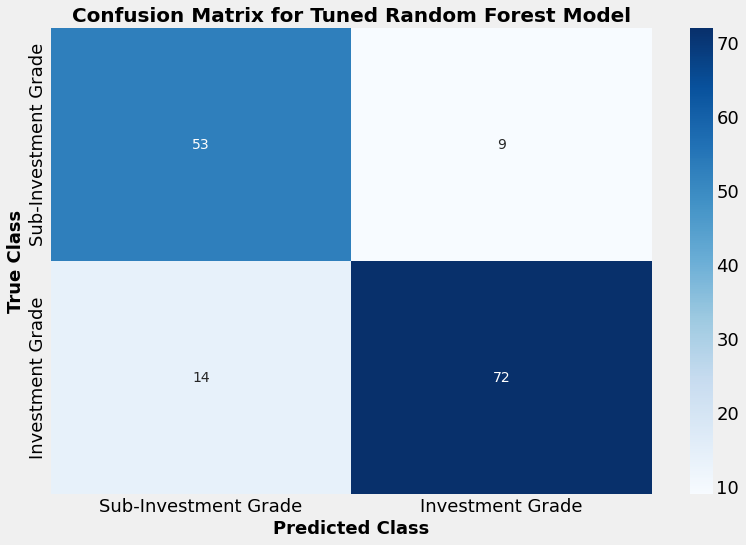

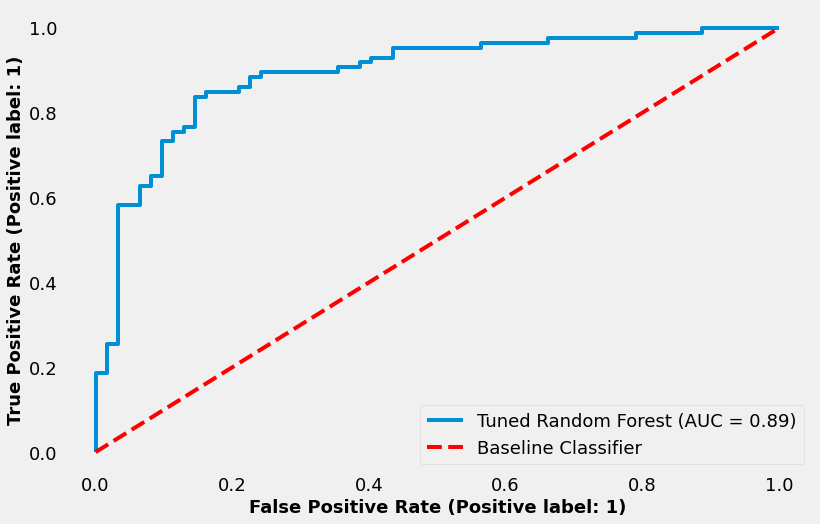

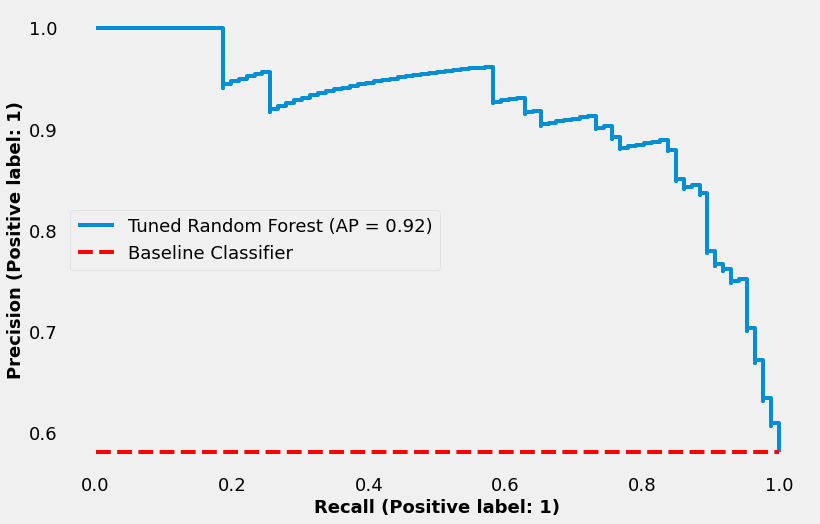

In [32]:
create_confusion_matrix(y_test, rf_mod_tuned_pred,'Tuned Random Forest')
create_roc_curve(rf_mod_tuned_fitted, X_test, y_test, 'Tuned Random Forest')
create_pr_curve(rf_mod_tuned_fitted, X_test, y_test, 'Tuned Random Forest')

Text(0.5, 1.0, 'Feature Importance vs. Feature')

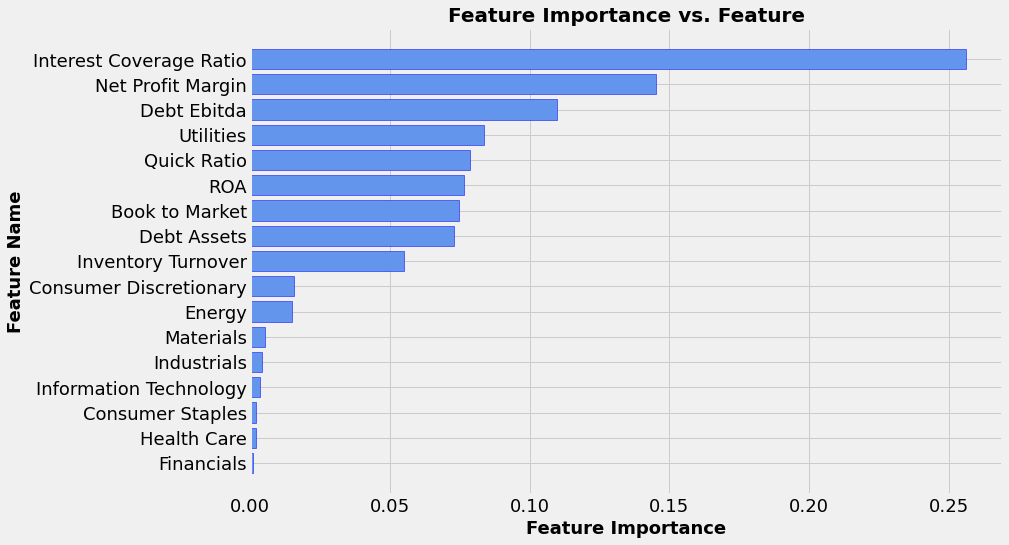

In [33]:
imp_scores = rf_mod_tuned_fitted.best_estimator_.feature_importances_
sorted_idx = imp_scores.argsort()
plt.barh([selectedFeatures_names[i] for i in sorted_idx],imp_scores[sorted_idx],color='cornflowerblue',edgecolor='blue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance vs. Feature')

### Exploring the Firms that were Misclassified (Random Forest Model)

In [34]:
# identify which samples were misclassified 
misclassified = np.where(y_test != rf_mod_tuned_pred)

len(misclassified[0])

23

In [35]:
# identify the misclassified samples
X_test_misclassified = X_test.iloc[misclassified]
X_test_misclassified['Y Pred'] = y_test.iloc[misclassified]
X_test_misclassified['Y Actual'] = rf_mod_tuned_pred[misclassified]

X_test_misclassified

,Consumer Discretionary,Energy,Health Care,Industrials,Information Technology,Materials,Utilities,ROA,Interest Coverage Ratio,Quick Ratio,Book to Market,Net Profit Margin,Debt Assets,Debt Ebitda,Inventory Turnover,Consumer Staples,Financials,Y Pred,Y Actual
131,0,1,0,0,0,0,0,0.069690,0.806202,0.552836,0.537839,0.039693,0.473743,1.839701,10.343687,0,0,1,0
806,0,0,0,0,0,1,0,0.202109,10.191667,1.111111,0.243826,0.077961,0.558124,1.440965,5.875897,0,0,0,1
22,0,1,0,0,0,0,0,0.118663,-1.254237,1.500271,0.330025,-0.255636,0.658999,3.481663,4.401530,0,0,1,0
344,1,0,0,0,0,0,0,0.183568,7.500000,0.948809,0.171186,0.041400,0.848136,1.849279,10.065156,0,0,0,1
365,0,0,0,1,0,0,0,0.139876,5.689567,2.581658,0.308610,0.068697,0.589174,2.257314,5.146787,0,0,1,0
560,0,0,0,1,0,0,0,0.260663,13.036775,2.049360,0.497121,0.064718,0.474381,0.987015,9.794126,0,0,0,1
74,0,0,0,0,0,0,0,0.115565,3.581762,0.983296,0.271331,0.015887,0.851796,3.847261,15.699224,1,0,1,0
258,0,0,0,0,0,1,0,0.062407,0.140523,1.884000,0.625963,-0.032782,0.435405,3.200416,3.184193,0,0,1,0
437,0,1,0,0,0,0,0,0.059026,-2.872038,1.990421,0.386131,-0.140724,0.367459,3.443730,15.184524,0,0,1,0
276,0,1,0,0,0,0,0,0.100586,2.741689,1.932601,0.633584,0.010823,0.515498,2.403825,5.695936,0,0,1,0
